## ${\textbf{Scope and Preparation}}$

Goal: provide a dashboard to the Finance department about the sales results for Q1.  

A JSON array that contains orders, following this structure:  

- Order ID
- Customer
    - ID
    - Name
    - Email
- Total Order price
- Creation date
- Line items. For each one:
    - ID
    - Product ID
    - Product SKU
    - Product Name
    - Price
    
To keep it simple, we removed taxes, discounts. Note also that all prices are in USD (US Dollars).

## ${\textbf{Libraries}}$

In [26]:
import pandas as pd
import numpy as np

import json
import requests

import time
import datetime

from IPython.display import Image

import pyodbc 
connStr = pyodbc.connect('DRIVER={SQL Server};SERVER=DESKTOP-LDBTQJ9; DATABASE=Q1Sales;Trusted_Connection=yes')


## ${\textbf{Task 1: Python. Data Manipulation and usage of external APIs}}$

### ${\textbf{Import Data}}$

In [2]:
# Load the data, contained in the orders data json file.
with open('orders.json','r') as file:
    lst = json.load(file) # List of nested dictionary initialization 

# Descriptive analysis of the data set. Here we just look at the data to gain some insight. 
# We do not apply any transformations or changes to the data.
df = pd.DataFrame(lst)
df.head()    

,created_at,customer,id,line_items,total_price
0,2020-03-07T14:31:11Z,"{'id': 47178, 'name': 'William Doe', 'email': ...",8369263756632563,"[{'id': 610448, 'product_id': 632910392, 'prod...",79.39
1,2020-03-01T09:16:30Z,"{'id': 94720, 'name': 'Emile Tumson', 'email':...",7262170348080494,"[{'id': 997208, 'product_id': 278266679, 'prod...",86.98
2,2020-01-01T09:17:03Z,"{'id': 59933, 'name': 'Ethan Jones', 'email': ...",7722055557038194,"[{'id': 759658, 'product_id': 573794972, 'prod...",36.99
3,2020-03-10T11:59:46Z,"{'id': 23955, 'name': 'Daniel Smith', 'email':...",4280852170163518,"[{'id': 317808, 'product_id': 477365777, 'prod...",55.98
4,2020-03-15T07:27:24Z,"{'id': 59933, 'name': 'Ethan Jones', 'email': ...",5058732129957127,"[{'id': 604665, 'product_id': 510650809, 'prod...",309.98


### ${\textbf{Usage of External APIs}}$

In [3]:
# We extract all the currency rates from USD to CAD from 2019-12-01 to 2020-04-01. 
response = requests.get('https://api.exchangeratesapi.io/history?start_at=2019-12-01&end_at=2020-04-01&base=USD&symbols=CAD')
print(response)

files = response.json()

rates= pd.DataFrame(files["rates"])

<Response [200]>


In [6]:
def GetCurrencyRate(df,rates):

    """
    Get the currency rate of each order based on creation date.
    If the order was created during the weekends or holidaies, we choose the exchange rate from the closest workday before that day.

    Arguments:
    df -- Orders dataframe
    rates -- All the currency rates from USD to CAD during the Q1, 2020
    
    Return:
    df_ex -- New orders dataframe with currency dates
    """
    ex = []
    for i in range(0,np.shape(df)[0]):
        date = df.iloc[i,0][:10]
        value= rates.get(date)
        day = datetime.timedelta(days = 1)
        today = date
        while value is None:
            today = datetime.datetime.strptime(today,'%Y-%m-%d') - day 
            today = today.strftime('%Y-%m-%d')
            value = rates.get(today)
        ex.append(value['CAD'])
    df['exchange rate'] = pd.DataFrame(ex)
    return df
    

In [7]:
df_ex = GetCurrencyRate(df,rates)
df_ex.head()

,created_at,customer,id,line_items,total_price,exchange rate
0,2020-03-07T14:31:11Z,"{'id': 47178, 'name': 'William Doe', 'email': ...",8369263756632563,"[{'id': 610448, 'product_id': 632910392, 'prod...",79.39,1.342008
1,2020-03-01T09:16:30Z,"{'id': 94720, 'name': 'Emile Tumson', 'email':...",7262170348080494,"[{'id': 997208, 'product_id': 278266679, 'prod...",86.98,1.344356
2,2020-01-01T09:17:03Z,"{'id': 59933, 'name': 'Ethan Jones', 'email': ...",7722055557038194,"[{'id': 759658, 'product_id': 573794972, 'prod...",36.99,1.299448
3,2020-03-10T11:59:46Z,"{'id': 23955, 'name': 'Daniel Smith', 'email':...",4280852170163518,"[{'id': 317808, 'product_id': 477365777, 'prod...",55.98,1.367779
4,2020-03-15T07:27:24Z,"{'id': 59933, 'name': 'Ethan Jones', 'email': ...",5058732129957127,"[{'id': 604665, 'product_id': 510650809, 'prod...",309.98,1.385897


## ${\textbf{Task 2: SQL}}$

### ${\textbf{Database Design}}$

#### ${\textbf{Normalization of Database}}$

Normalization of relational database helps us avoid redundancy and anomaly. It helps us insert, update, and delete records easily, especially for large and complex eCommerce data points. Also, it performs better than excel files when we want to share the dataset among a group or understand the relationship between variables quickly.

I tried to design a database in SQL Server that satisfies the Third Normal Form. The ER diagram of the database is shown below. It satisfies the following conditions:
    - All non-key attributes are fully functional dependent on the primary key
    - There is no transitive functional dependency
    - Contains only atomic values
    - There are no repeating groups

One feature changed in one data table will be automatically changed in all the other data tables that contain this feature.
    

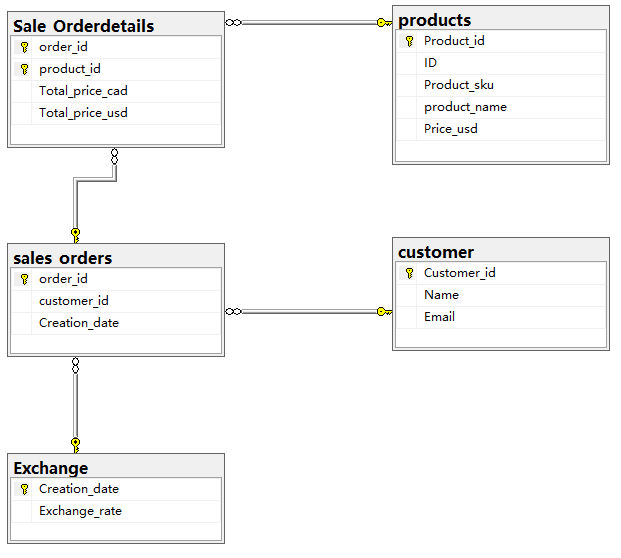

In [8]:
Image(filename='relation_diagram.png')

### ${\textbf{SQL Code}}$

```mysql
-- USE Ecommerce;

CREATE TABLE customer
 (
  Customer_id            INT          NOT NULL IDENTITY,
  Name                   VARCHAR(50),
  Email                  VARCHAR(100) ,
  
 
 CONSTRAINT pk_customer PRIMARY KEY(Customer_id)
 );

 CREATE TABLE products
(
 Product_id                    INT    NOT NULL IDENTITY,
 ID                            INT,
 Product_sku                   VARCHAR(40) ,
 Product_name                  VARCHAR(40) ,
 Price_usd                     Float(20) ,
 
 CONSTRAINT pk_product PRIMARY KEY(Product_id)
 );


  CREATE TABLE sales_orders
 (
  order_id            INT     NOT NULL IDENTITY,
  Customer_id         INT     ,
  Creation_date       Date    , 

  CONSTRAINT pk_sales_orders PRIMARY KEY(order_id)
 );


 CREATE TABLE Sale_Orderdetails
 (
  order_id               INT    NOT NULL,
  Product_id             INT    NOT NULL,
  Total_price_cad        Float(20),
  Total_price_usd        Float(20),  

  CONSTRAINT pk_orderproduct PRIMARY KEY(product_id,order_id)
 );


 CREATE TABLE Exchange
( 
 Creation_date     Date   Not Null,
 Exchange_rate     Float(20)

 CONSTRAINT pk_creationdate PRIMARY KEY(Creation_date)
);


 AlTER TABLE dbo.sales_orders
   ADD CONSTRAINT FK_Creation_date FOREIGN KEY (Creation_date)
       REFERENCES dbo.Exchange (Creation_date)
       ON DELETE CASCADE
       ON UPDATE CASCADE
;


  ALTER TABLE dbo.sales_orders
    ADD CONSTRAINT FK_customer_id FOREIGN KEY (customer_id)
	REFERENCES dbo.customer (customer_id)
	ON DELETE CASCADE
	ON UPDATE CASCADE
;


  ALTER TABLE dbo.sale_orderdetails
    ADD CONSTRAINT FK_product FOREIGN KEY (product_id)
	REFERENCES dbo.products (product_id)
	ON DELETE CASCADE
	ON UPDATE CASCADE
;

  ALTER TABLE dbo.sale_orderdetails
    ADD CONSTRAINT FK_order FOREIGN KEY (order_id)
	REFERENCES dbo.sales_orders (order_id)
	ON DELETE CASCADE
	ON UPDATE CASCADE
;

```

### ${\textbf{Prepare Data for SQL Database}}$

#### ${\textbf{Customer}}$

In [9]:
customer =  pd.DataFrame.from_dict(list(df['customer']))
customer.columns = ['email', 'customer_id','customer_name']
customer = customer.drop_duplicates()
customer.head()

,email,customer_id,customer_name
0,william.doe@gmail.com,47178,William Doe
1,emile.tumson@gmail.com,94720,Emile Tumson
2,ethan.jones@gmail.com,59933,Ethan Jones
3,daniel.smith@gmail.com,23955,Daniel Smith


#### ${\textbf{Summary Data File}}$

In [10]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in lst: 
    data_row = data['line_items'] 
    time = data['id']    
    for row in data_row: 
        row['order id']= time 
        rows.append(row) 

# using data frame 
product = pd.DataFrame(rows)

In [11]:
df_merged = pd.concat([df_ex, customer], axis=1)
df_merged.rename(columns = {'id':'order id'}, inplace = True) 

In [12]:
df_final = pd.merge(product, df_merged, how="left", on=["order id"])

In [13]:
df_final['price_cad']=df_final['price']*df_final['exchange rate']
df_final['total_price_cad']=df_final['total_price']*df_final['exchange rate']
df_final.rename(columns = {'price':'price_usd', 'total_price':'total_price_usd'}, inplace = True) 

In [14]:
df_final = df_final[['created_at', 'order id', 'customer_id', 'customer_name', 'email','id','price_usd','price_cad','product_id','product_name','product_sku', 'total_price_usd','total_price_cad','exchange rate']]
df_final.head()

,created_at,order id,customer_id,customer_name,email,id,price_usd,price_cad,product_id,product_name,product_sku,total_price_usd,total_price_cad,exchange rate
0,2020-03-07T14:31:11Z,8369263756632563,47178.0,William Doe,william.doe@gmail.com,610448,29.40,39.455028,632910392,Purple Punch 2.0 Dried Flower,PPLEPUNCH20-05,79.39,106.541996,1.342008
1,2020-03-07T14:31:11Z,8369263756632563,47178.0,William Doe,william.doe@gmail.com,997208,49.99,67.086968,278266679,Grandpa's Stash Dried Flower,GPSTASH-01,79.39,106.541996,1.342008
2,2020-03-01T09:16:30Z,7262170348080494,94720.0,Emile Tumson,emile.tumson@gmail.com,997208,49.99,67.204376,278266679,Grandpa's Stash Dried Flower,GPSTASH-01,86.98,116.932118,1.344356
3,2020-03-01T09:16:30Z,7262170348080494,94720.0,Emile Tumson,emile.tumson@gmail.com,759658,36.99,49.727743,573794972,Sage N Sour Dried Flower,SAGENSOUR-01,86.98,116.932118,1.344356
4,2020-01-01T09:17:03Z,7722055557038194,59933.0,Ethan Jones,ethan.jones@gmail.com,759658,36.99,48.066585,573794972,Sage N Sour Dried Flower,SAGENSOUR-01,36.99,48.066585,1.299448


#### ${\textbf{Products}}$

In [15]:
product = product[['product_id','id','product_sku','product_name','price']]
product = product.drop_duplicates()
product.head()

,product_id,id,product_sku,product_name,price
0,632910392,610448,PPLEPUNCH20-05,Purple Punch 2.0 Dried Flower,29.40
1,278266679,997208,GPSTASH-01,Grandpa's Stash Dried Flower,49.99
3,573794972,759658,SAGENSOUR-01,Sage N Sour Dried Flower,36.99
5,477365777,317808,GOGPR-07,Glueberry OG Pre-Rolls,5.99
6,694165761,771854,HYBTINC-03,Hybrid Blend THC Tincture,49.99


#### ${\textbf{Sale Orderdetails}}$

In [16]:
Orderdetails = df_final[[ 'order id', 'product_id', 'total_price_usd','total_price_cad']]
Orderdetails = Orderdetails.drop_duplicates()
Orderdetails.head()

,order id,product_id,total_price_usd,total_price_cad
0,8369263756632563,632910392,79.39,106.541996
1,8369263756632563,278266679,79.39,106.541996
2,7262170348080494,278266679,86.98,116.932118
3,7262170348080494,573794972,86.98,116.932118
4,7722055557038194,573794972,36.99,48.066585


#### ${\textbf{Sale Orders}}$

In [17]:
SaleOrders = df_final[['created_at', 'order id', 'customer_id']]
SaleOrders = SaleOrders.drop_duplicates()
SaleOrders.head()

,created_at,order id,customer_id
0,2020-03-07T14:31:11Z,8369263756632563,47178.0
2,2020-03-01T09:16:30Z,7262170348080494,94720.0
4,2020-01-01T09:17:03Z,7722055557038194,59933.0
5,2020-03-10T11:59:46Z,4280852170163518,23955.0
7,2020-03-15T07:27:24Z,5058732129957127,NaN


#### ${\textbf{Exchange}}$

In [18]:
Exchange = df_final[['created_at','exchange rate']]
Exchange = Exchange.drop_duplicates()
Exchange.head()

,created_at,exchange rate
0,2020-03-07T14:31:11Z,1.342008
2,2020-03-01T09:16:30Z,1.344356
4,2020-01-01T09:17:03Z,1.299448
5,2020-03-10T11:59:46Z,1.367779
7,2020-03-15T07:27:24Z,1.385897


### ${\textbf{Export Data}}$

In [19]:
# create a csv file
now = datetime.datetime.today()
file_name ="orders_"+ now.strftime('%Y-%m-%d')+'.csv'
df_final.to_csv(file_name, index=False, header=True)

In [22]:
cursor = connStr.cursor()

for index,row in customer.iterrows():
    cursor.execute("set identity_insert customer ON INSERT INTO dbo.customer([Customer_id],[Name],[Email])values (?, ?,?) set identity_insert customer OFF", 
                   row['customer_id'], 
                   row['customer_name'], 
                   row['email']) 
    
for index,row in product.iterrows():
    cursor.execute("set identity_insert products ON INSERT INTO dbo.products([Product_id],[ID],[Product_sku],[Product_name],[Price_usd])values (?, ?,?,?,?) set identity_insert products OFF", 
                   row['product_id'], 
                   row['id'], 
                   row['product_sku'],
                   row['product_name'], 
                   row['price']) 

for index,row in SaleOrders.iterrows():
    cursor.execute("set identity_insert sales_orders ON INSERT INTO dbo.sales_orders([order_id],[Customer_id],[Creation_date])values (?, ?,?) set identity_insert sales_orders OFF", 
                   row['order id'], 
                   row['customer_id'], 
                   row['created_at']) 

for index,row in Orderdetails.iterrows():
    cursor.execute("set identity_insert Sale_Orderdetails ON INSERT INTO dbo.Sale_Orderdetails([order_id],[Product_id],[Total_price_cad],[Total_price_usd])values (?, ?,?,?) set identity_insert Sale_Orderdetails OFF", 
                   row['order id'], 
                   row['product_id'], 
                   row['total_price_usd'],
                   row['total_price_cad']) 
    
for index,row in Exchange.iterrows():
    cursor.execute("set identity_insert Exchange ON INSERT INTO dbo.Exchange([Creation_date],[Exchange_rate])values (?, ?) set identity_insert Exchange OFF", 
                   row['created_at'], 
                   row['exchange_rate'])
    
connStr.commit()
cursor.close()
connStr.close()